In [1]:
from pathlib import Path
import random
import numpy as np
import torch
from torch import nn
from torch import Tensor
from torch.utils.data import (
    Dataset,
    DataLoader,
    random_split,
)
import torchvision.transforms.v2 as T
from torchvision.transforms.v2.functional import to_pil_image
from torchvision.io import read_image
from torchvision import models
from torchview import draw_graph
from sklearn.metrics import (
confusion_matrix, ConfusionMatrixDisplay)
from kagglehub import dataset_download
import tqdm
import matplotlib.pyplot as plt


plt.rcParams["savefig.bbox"] = 'tight'

/users/seyang/opt/micromamba/envs/lec-24-2-dl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# device = torch.device('cpu')
device = torch.device('cuda:1')

In [3]:
torch.set_num_threads(8)

In [4]:
# Set a fixed seed for reproducibility across different libraries
seed = 1337
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Model

In [ ]:
class PistachioImageDataset(Dataset):
    """
    This dataset includes images of two types of pistachios: 'Kirmizi_Pistachio' and 
    'Siirt_Pistachio'. The images are loaded and assigned corresponding labels for use in
    machine learning tasks.
    """

    
    LABEL_NAME_LIST = [
        'Kirmizi_Pistachio',
        'Siirt_Pistachio',
    ]

    def __init__(
        self,
        transform: T.Transform | None = None,
        target_transform: T.Transform | None = None,
    ) -> None:
        """
        """
        self.transform = transform
        self.target_transform = target_transform
        
        
        root = dataset_download("muratkokludataset/pistachio-image-dataset")

        data_dir = Path(
            root,
            'Pistachio_Image_Dataset',
            'Pistachio_Image_Dataset',
        )


        # Load images and labels
        example_list: list[tuple[Tensor, int]] = []
        for label, label_name in enumerate(self.LABEL_NAME_LIST):
            label_dir = data_dir / label_name

            image_path_list = list(label_dir.glob('*.jpg'))
            for image_path in tqdm.tqdm(image_path_list, desc=f'loading {label_name}'):
                image = read_image(image_path)
                example_list.append((image, label))

        self.example_list = example_list

    def __len__(self) -> int:
        return len(self.example_list)


    def __getitem__(self, index: int) -> tuple[Tensor, int]:
        image, target = self.example_list[index]
        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return image, target

In [7]:
dataset = PistachioImageDataset()

loading Siirt_Pistachio: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 916/916 [00:01<00:00, 628.23it/s]


In [ ]:
# adapted from https://pytorch.org/vision/stable/auto_examples/others/plot_visualization_utils.html
def show(imgs):
    """
    """
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

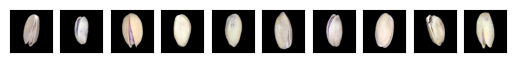

In [ ]:
show([dataset[idx][0] for idx in np.random.randint(low=0, high=len(dataset), size=10)])

# Preprocessing and Data Augmentation

## Data Augmentation
- RandomResizedCrop: Randomly crops a section of the image, then resizes it to 56x56 pixels.
- RandomHorizontalFlip: Randomly flips the image horizontally with a probability of 0.5.

## Preprocessing
- ToDtype: Converts the image to a tensor of dtype torch.float32 and scales pixel values to [0, 1].
- Normalize: Normalizes the image using mean and standard deviation values typical for RGB images. Mean and standard deviation for each channel (RGB) are dreived from ImageNet dataset.

In [9]:
dataset.transform = T.Compose([
    T.RandomResizedCrop(size=(56, 56), antialias=True),
    T.RandomHorizontalFlip(p=0.5),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

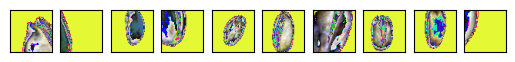

In [10]:
show([dataset[idx][0] for idx in np.random.randint(low=0, high=len(dataset), size=10)])

# Dataset splitting

In [11]:
train_set, val_set, test_set = random_split(
    dataset=dataset,
    lengths=[0.64, 0.16, 0.20],
    generator=torch.Generator().manual_seed(1337),
)

# Model

In [12]:
class PistachioImageClassifier(nn.Module):
    """
    A neural network model for classifying pistachio images.

    This classifier uses a specified backbone model for feature extraction, followed
    by a linear classification head that outputs a single logit for binary classification.

    Attributes:
        backbone (nn.Module): The feature extraction model (e.g., a pretrained CNN).
        classification_head (nn.Linear): A linear layer that maps extracted features to a single output.
    """

    def __init__(
        self, 
        backbone,
    ) -> None:
        """
        Initializes the PistachioImageClassifier.

        Args:
            backbone (Module): A neural network model used as the backbone for feature extraction.
        """
        super().__init__()

        # The backbone network takes 
        self.backbone = backbone

        # Define the classification head with 1000 input features and 1 output feature (binary classification).
        self.classification_head = nn.Linear(
            in_features=1000,
            out_features=1
        )

    def forward(
        self,
        input: Tensor,
    ) -> Tensor:
        """
        Defines the forward pass of the model.

        Args:
            input (Tensor): The input tensor containing images, with shape (batch_size, channels, height, width).

        Returns:
            Tensor: The output logits tensor of shape (batch_size,), representing classification scores.
        """
        # Extract features using the backbone
        embed = self.backbone(input)
    
        logits = self.classification_head(embed)

        # Squeeze logits to remove extra dimensions
        logits = logits.squeeze()
        return logits

Initialize a ResNet-18 model as the backbone for feature extraction, pre-trained on the ImageNet dataset for improved initial performance.

Alternatively, you can use EfficientNet-B0 as the backbone by uncommenting the lines below.
This model is also pre-trained on ImageNet and is more lightweight, which can be beneficial for lower-compute environments or when a smaller model is preferred.

In [13]:
backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
# backbone = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

Create an instance of the PistachioImageClassifier, using the ResNet-18 backbone to extract features, and add a classification head for pistachio classification

In [14]:
model = PistachioImageClassifier(
    backbone=backbone,
)

Move the model to the specified device (e.g., GPU or CPU)

In [24]:
model = model.to(device)

In [16]:
num_parameters = sum(each.numel() for each in model.parameters() if each.requires_grad)
print(f'{num_parameters / 1e6:.1f}M parameters')

11.7M parameters


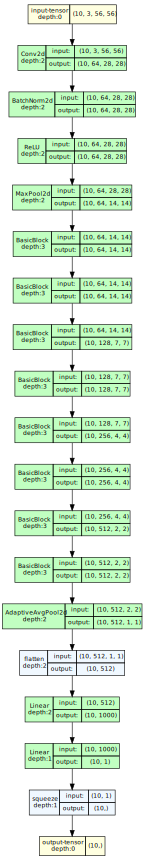

In [17]:
visual_batch_size = 10
model_graph = draw_graph(model, input_size=(visual_batch_size, 3, 56, 56))
 
model_graph.visual_graph

# Optimizer
Initialize the AdamW optimizer for training the model, which uses weight decay to improve generalization by preventing overfitting.

In [18]:
optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=3e-4,
)

# Criterion

Count the occurrences of each unique label in the dataset

In [19]:
_, (pos, neg) = torch.unique(
    input=torch.tensor([label for _, label in train_set]),
    return_counts=True,
)

Calculate the weight for the positive class to address class imbalance

In [20]:
pos_weight = neg / pos
print(f'{pos=}, {neg=} -> {pos_weight=}')

pos=tensor(791), neg=tensor(584) -> pos_weight=tensor(0.7383)


This weight adjustment will make the model more sensitive to the minority class

In [21]:
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
criterion = criterion.to(device)

# Hyperparameters

In [22]:
max_epochs: int = 20
threshold: float = 0.5

# Training Loop

In [25]:
train_loader = DataLoader(
    dataset=train_set,
    batch_size=64,
)

val_loader = DataLoader(
    dataset=train_set,
    batch_size=128
)


for epoch in range(0, max_epochs + 1):
    if epoch > 0:
        model.train()
        for image, target in tqdm.tqdm(train_loader, desc='training'):
            image, target = image.to(device), target.to(device)
            optimizer.zero_grad()
            logits = model(input=image)
            loss = criterion(
                input=logits, 
                target=target.to(logits.dtype),
            )
            loss.backward()
            optimizer.step()

    
    with torch.no_grad():
        # validation
        model.eval()

        val_loss = 0
        val_total = 0
        val_correct = 0

        for image, target in tqdm.tqdm(val_loader, desc='validation'):
            image, target = image.to(device), target.to(device)
            logits = model(input=image)
            score = logits.sigmoid()
            prediction = score.gt(threshold).long()

            loss = criterion(
                input=logits, 
                target=target.to(logits.dtype), 
            )

            val_loss += len(target) * loss.item()
            val_total += len(target)
            val_correct += prediction.eq(target).sum().item()
    
        val_loss /= val_total
        val_acc = val_correct / val_total
        print(f'{epoch=: >6d}: Loss={val_loss:.3f} Accuracy={100 * val_acc:.2f} %')


validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  8.96it/s]


epoch=     0: Loss=1.017 Accuracy=54.47 %


validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.13it/s]


epoch=     1: Loss=0.729 Accuracy=72.80 %


validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.27it/s]


epoch=     2: Loss=0.287 Accuracy=85.31 %


validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00, 10.44it/s]


epoch=     3: Loss=0.238 Accuracy=87.93 %


validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.04it/s]


epoch=     4: Loss=0.253 Accuracy=88.07 %


validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.17it/s]


epoch=     5: Loss=0.149 Accuracy=93.09 %


validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.64it/s]


epoch=     6: Loss=0.187 Accuracy=92.58 %


validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.63it/s]


epoch=     7: Loss=0.331 Accuracy=83.85 %


validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.74it/s]


epoch=     8: Loss=0.132 Accuracy=93.60 %


validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00, 10.82it/s]


epoch=     9: Loss=0.470 Accuracy=75.27 %


validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.03it/s]


epoch=    10: Loss=0.137 Accuracy=93.38 %


validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00, 10.43it/s]


epoch=    11: Loss=0.151 Accuracy=92.65 %


validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.53it/s]


epoch=    12: Loss=0.173 Accuracy=91.56 %


validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.63it/s]


epoch=    13: Loss=0.138 Accuracy=92.95 %


validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.43it/s]


epoch=    14: Loss=0.131 Accuracy=94.25 %


validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00, 10.76it/s]


epoch=    15: Loss=0.130 Accuracy=92.95 %


validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.72it/s]


epoch=    16: Loss=0.150 Accuracy=94.04 %


validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.65it/s]


epoch=    17: Loss=0.115 Accuracy=94.91 %


validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.48it/s]


epoch=    18: Loss=0.132 Accuracy=93.53 %


validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.01it/s]


epoch=    19: Loss=0.120 Accuracy=94.62 %


validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.64it/s]

epoch=    20: Loss=0.365 Accuracy=86.18 %


# Testing
After selecting your backbone and hyperparameters, you can evaluate your final model on the test set.

In [26]:
test_loader = DataLoader(
    dataset=test_set,
    batch_size=128,
)

In [27]:
# confusion matrix
cm = np.zeros((2, 2), dtype=np.int64)

with torch.no_grad():
    model.eval()

    for image, target in tqdm.tqdm(test_loader, desc='test'):
        image, target = image.to(device), target.to(device)
        logits = model(input=image)
        score = logits.sigmoid()
        prediction = score.gt(threshold).long()

        cm += confusion_matrix(
            y_true=target.cpu().numpy(), 
            y_pred=prediction.cpu().numpy(),
        )

test: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.10it/s]


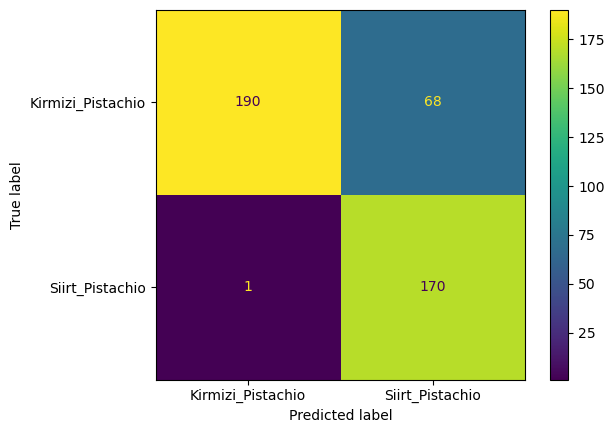

In [28]:
plot = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=PistachioImageDataset.LABEL_NAME_LIST
)

plot.plot()